# 機械学習
## 本章では，Fabio Gasparetti氏が公開しているNews Aggregator Data Setを用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．
#### https://nlp100.github.io/ja/ch06.html

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/iamtatsuki05/NLP_100/blob/fix_all_merge/NLP_100_6.ipynb)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# データの入手・整形
## News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

###ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
##情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
###抽出された事例をランダムに並び替える．
###抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．
###学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip

--2022-04-03 08:20:23--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  68.1MB/s    in 0.4s    

2022-04-03 08:20:23 (68.1 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]



In [ ]:
!unzip NewsAggregatorDataset.zip

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [ ]:
f = open('readme.txt', 'r')
data = f.read()
print(data)

SUMMARY: Dataset of references (urls) to news web pages

DESCRIPTION: Dataset of references to news web pages collected from an online aggregator in the period from March 10 to August 10 of 2014. The resources are grouped into clusters that represent pages discussing the same news story. The dataset includes also references to web pages that point (has a link to) one of the news page in the collection.

TAGS: web pages, news, aggregator, classification, clustering

LICENSE: Public domain - Due to restrictions on content and use of the news sources, the corpus is limited to web references (urls) to web pages and does not include any text content. The references have been retrieved from the news aggregator through traditional web browsers. 

FILE ENCODING: UTF-8

FORMAT: Tab delimited CSV files. 

DATA SHAPE AND STATS: 422937 news pages and divided up into:

152746 	news of business category
108465 	news of science and technology category
115920 	news of business category
 45615 	news of

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/newsCorpora.csv' , header=None , sep='\t' , names=['ID' , 'TITLE' , 'URL' , 'PUBLISHER' , 'CATEGORY' , 'STORY' , 'HOSTNAME' , 'TIMESTAMP'])
df = df.loc[df['PUBLISHER'].isin(['Reuters' , 'Huffington Post' , 'Businessweek' , 'Contactmusic.com' , 'Daily Mail']) , ['TITLE' , 'CATEGORY']]

dataset_train , other = train_test_split(df , test_size=0.2, shuffle=True, random_state=42 , stratify=df['CATEGORY'])
dataset_valid , dataset_test = train_test_split(other , test_size=0.5, shuffle=True, random_state=42 , stratify=other['CATEGORY'])

print('train:' , dataset_train.describe())
print('test:' , dataset_test.describe())
print('valid:' , dataset_valid.describe())

train:                                              TITLE CATEGORY
count                                        10672    10672
unique                                       10520        4
top     Deals of the day- Mergers and acquisitions        b
freq                                             6     4502
test:                                                     TITLE CATEGORY
count                                                1334     1334
unique                                               1330        4
top     German bonds firm up as investors prepare for ...        b
freq                                                    2      563
valid:                                                     TITLE CATEGORY
count                                                1334     1334
unique                                               1329        4
top     Coachella Tickets Among the Hottest, Priciest ...        b
freq                                                    2      562


In [ ]:
dataset_train.to_csv('./train.txt' , sep='\t' , index=False)
dataset_test.to_csv('./test.txt' , sep='\t' , index=False)
dataset_valid.to_csv('./valid.txt' , sep='\t' , index=False)

# 特徴量抽出
## 学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [ ]:
#CATEGORY	News category (b = business, t = science and technology, e = entertainment, m = health)
df = pd.concat([dataset_train , dataset_test , dataset_valid] , axis=0)
df

,TITLE,CATEGORY
291466,Kanye West - Kanye West Celebrates Father's Da...,e
101653,Fitch Affirms Ukraine's City of Kyiv at 'CCC',b
253488,Sony CEO Says First TV Profit in Decade Possib...,t
195515,The United States of Comcast: Follow the $19M ...,b
75766,New Music From Michael Jackson Set To Be Relea...,e
...,...,...
350851,Everything Is Doom And Gloom In First Trailer ...,e
365283,Potato Salad Kickstarter Has Raised HOW MUCH?,e
403139,Chris Pratt - Chris Pratt Embarrassed By Weigh...,e
57043,"Euro hovers near three-week low, inflation key...",b


In [ ]:
#ID修正
import string
import re
df.reset_index(drop=True, inplace=True)
#小文字化
df['TITLE'] = df['TITLE'].str.lower()
#記号変換
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
df['TITLE'] = df['TITLE'].str.translate(table)
df

,TITLE,CATEGORY
0,kanye west kanye west celebrates father s da...,e
1,fitch affirms ukraine s city of kyiv at ccc,b
2,sony ceo says first tv profit in decade possib...,t
3,the united states of comcast follow the 19m ...,b
4,new music from michael jackson set to be relea...,e
...,...,...
13335,everything is doom and gloom in first trailer ...,e
13336,potato salad kickstarter has raised how much,e
13337,chris pratt chris pratt embarrassed by weigh...,e
13338,euro hovers near three week low inflation key...,b


In [ ]:
#train , test , valid = df[:len(train)] , df[len(train):len(train) + len(test)] , df[len(train) + len(test):] 

##trainとvalidは同じ状態で前処理を行って直前に直前に分けたほうが良いここで時間がかかった

# #文章のベクトル化
# from sklearn.feature_extraction.text import TfidfVectorizer

# vec_tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2))

# train_tmp = vec_tfidf.fit_transform(train['TITLE'])
# test_tmp = vec_tfidf.fit_transform(test['TITLE'])
# valid_tmp = vec_tfidf.fit_transform(valid['TITLE'])

# X_train = pd.DataFrame(train_tmp.toarray())
# X_test = pd.DataFrame(test_tmp.toarray())
# X_valid = pd.DataFrame(valid_tmp.toarray())
# X_test

In [ ]:
#文章のベクトル化
from sklearn.feature_extraction.text import TfidfVectorizer

vec_tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2))

df_tmp = vec_tfidf.fit_transform(df['TITLE'])

df = pd.DataFrame(df_tmp.toarray(), columns=vec_tfidf.get_feature_names())
X_train , X_test , X_valid = df[:len(dataset_train)] , df[len(dataset_train):len(dataset_train) + len(dataset_test)] , df[len(dataset_train) + len(dataset_test):]
X_train

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,10,10 billion,10 year,100,11,12,13,1300,14,15,...,young,your,your mother,yr,yr high,yuan,zac,zac efron,zendaya,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
10668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
10669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
10670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.329358,0.0,0.0,0.0,0.0


In [ ]:
#参考https://qiita.com/Yuu94/items/ca1ad7eb1dd5c9686c5a
#https://qiita.com/tag1216/items/df6c93bdb823dd48af6c
#https://pyhoo.jp/upper-lower

# 学習
## 51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [ ]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(penalty='l2' , solver='sag' , random_state=42 , max_iter=100)
lg.fit(X_train , dataset_train['CATEGORY'])

LogisticRegression(random_state=42, solver='sag')

In [ ]:
#https://qiita.com/fujin/items/f5656afc8a40fcf55386

# 予測
## 52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [ ]:
train_pred = lg.predict(X_train)
train_pred

array(['e', 'b', 'b', ..., 'b', 'b', 'b'], dtype=object)

In [ ]:
test_pred = lg.predict(X_test)
test_pred

array(['b', 'e', 'e', ..., 'b', 'b', 'e'], dtype=object)

# 正解率の計測
## 52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ

In [ ]:
from sklearn.metrics import accuracy_score
#train
train_accuracy = accuracy_score(dataset_train['CATEGORY'] , train_pred)
print(f'score：{train_accuracy:.3f}')

score：0.929


In [ ]:
#test
test_accuracy = accuracy_score(dataset_test['CATEGORY'] , test_pred)
print(f'score：{test_accuracy:.3f}')

score：0.884


# 混同行列の作成
## 52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ

[[4362   85    9   46]
 [  49 4167    2    5]
 [  90  128  500   10]
 [ 192  136    6  885]]


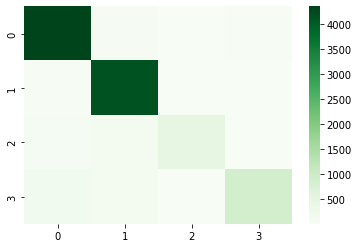

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#train
train_cm = confusion_matrix(dataset_train['CATEGORY'] , train_pred)
print(train_cm)
sns.heatmap(train_cm , cmap = 'Greens')

[[527  23   2  11]
 [ 11 516   0   1]
 [ 15  26  47   3]
 [ 41  22   0  89]]


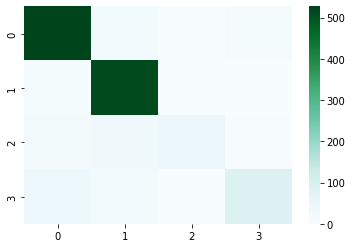

In [ ]:
#test
test_cm = confusion_matrix(dataset_test['CATEGORY'] , test_pred)
print(test_cm)
sns.heatmap(test_cm , cmap = 'BuGn')

In [ ]:
#参考https://note.nkmk.me/python-sklearn-confusion-matrix-score/

# 適合率，再現率，F1スコアの計測
## 52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [ ]:
# from sklearn.metrics import precision_score, recall_score, f1_score
# import numpy as np

# # 適合率
# precision = precision_score(test['CATEGORY'] , test_pred , average=None , labels=['b' , 'e' , 't' , 'm'])
# precision = np.append(precision , precision_score(test['CATEGORY'] , test_pred , average='micro'))
# precision = np.append(precision , precision_score(test['CATEGORY'] , test_pred , average='macro'))

# # 再現率
# recall = recall_score(test['CATEGORY'] , test_pred , average=None , labels=['b' , 'e' , 't' , 'm'])
# recall = np.append(recall , recall_score(test['CATEGORY'] , test_pred , average='micro'))
# recall = np.append(recall , recall_score(test['CATEGORY'] , test_pred , average='macro'))

# # F1スコア
# f1 = f1_score(test['CATEGORY'] , test_pred , average=None , labels=['b' , 'e' , 't' , 'm'])
# f1 = np.append(f1 , f1_score(test['CATEGORY'] , test_pred , average='micro'))
# f1 = np.append(f1 , f1_score(test['CATEGORY'] , test_pred , average='macro'))

# score_dataframe = pd.DataFrame({'適合率': precision , '再現率': recall , 'F1スコア': f1} ,
#                         index=['b' , 'e' , 't' , 'm' , 'マイクロ平均' , 'マクロ平均'])
# score_dataframe

In [ ]:
from sklearn.metrics import classification_report
# target_names = ['b' , 'e' , 'm' , 't']
print('test_data\n')
print(classification_report(dataset_test['CATEGORY'] , test_pred))

test_data

              precision    recall  f1-score   support

           b       0.89      0.94      0.91       563
           e       0.88      0.98      0.93       528
           m       0.96      0.52      0.67        91
           t       0.86      0.59      0.70       152

    accuracy                           0.88      1334
   macro avg       0.90      0.75      0.80      1334
weighted avg       0.89      0.88      0.88      1334



In [ ]:
#参考https://qiita.com/g-k/items/14bf10cce79f0db72b24
#https://qiita.com/shoku-pan/items/cef42c9a3f472eb571b9
#https://note.nkmk.me/python-sklearn-confusion-matrix-score/
# https://gotutiyan.hatenablog.com/entry/2020/09/09/111840

# 特徴量の重みの確認Permalink
## 52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [ ]:
import numpy as np
cols = X_train.columns.values
index = [_ for _ in range(1, 11)]
for category , score in zip(lg.classes_, lg.coef_):
    print(f'【カテゴリ】{category}')
    high = pd.DataFrame(cols[np.argsort(score)[::-1][:10]] , columns = ['重みの高い特徴量'] , index = index)
    low = pd.DataFrame(cols[np.argsort(score)[:10]] , columns = ['重みの低い特徴量'] , index = index)
    frame = pd.concat([high , low] , axis=1)
    print(frame)

【カテゴリ】b
     重みの高い特徴量   重みの低い特徴量
1         fed        and
2       china        her
3         ecb      ebola
4        bank  microsoft
5      stocks   facebook
6         oil        she
7   obamacare       drug
8        euro      apple
9     ukraine       star
10     dollar      video
【カテゴリ】e
      重みの高い特徴量 重みの低い特徴量
1   kardashian   update
2        chris       us
3        movie   google
4         star    china
5          she      ceo
6         film    study
7          kim       gm
8          her     says
9         paul    could
10     wedding    apple
【カテゴリ】m
   重みの高い特徴量  重みの低い特徴量
1     ebola  facebook
2    cancer        gm
3     study     apple
4      drug   climate
5       fda       ceo
6      mers    google
7       cdc   twitter
8    health      deal
9     could     sales
10    cases    amazon
【カテゴリ】t
      重みの高い特徴量  重みの低い特徴量
1       google       fed
2     facebook    stocks
3        apple      drug
4    microsoft      home
5      climate       her
6         nasa  american
7       mobi

In [ ]:
#参考https://gotutiyan.hatenablog.com/entry/2020/09/08/122621#classes_%E3%81%A9%E3%81%AE%E3%83%A9%E3%83%99%E3%83%AB%E3%81%8C%E3%81%A9%E3%81%AEID%E3%81%AA%E3%81%AE%E3%81%8B%E3%82%92%E5%8F%96%E5%BE%97
#https://qiita.com/rubberduck/items/c2ade1ac10c80651f4b1

# 正則化パラメータの変更
## ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

In [ ]:
from sklearn.linear_model import LogisticRegression

result = []
Cs = [10 ** i for i in range(-3 , 3)]

for C in Cs:
    lg = LogisticRegression(penalty = 'l2' , solver = 'sag' , random_state = 42 , max_iter = 100 , C = C)
    lg.fit(X_train , dataset_train['CATEGORY'])
    # 予測
    train_pred = lg.predict(X_train)
    valid_pred = lg.predict(X_valid)
    test_pred = lg.predict(X_test)

    # 誤差
    train_accuracy = accuracy_score(dataset_train['CATEGORY'] , train_pred)
    valid_accuracy = accuracy_score(dataset_valid['CATEGORY'] , valid_pred)
    test_accuracy = accuracy_score(dataset_test['CATEGORY'] , test_pred)

    # 結果
    result.append([C , train_accuracy , valid_accuracy , test_accuracy])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


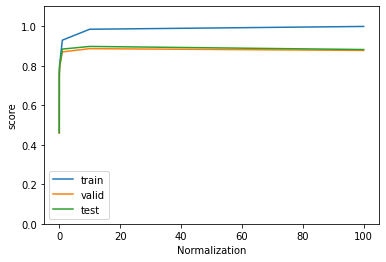

In [ ]:
result = np.array(result).T
plt.plot(result[0] , result[1] , label = 'train')
plt.plot(result[0] , result[2] , label = 'valid')
plt.plot(result[0] , result[3] , label = 'test')
plt.ylim(0 , 1.1)
plt.ylabel('score')
plt.xlabel('Normalization')
plt.legend()
plt.show()

In [ ]:
#参考http://harmonizedai.com/article/%E3%83%91%E3%83%A9%E3%83%A1%E3%83%BC%E3%82%BF%E3%83%BC-c%E3%80%80%E3%83%AD%E3%82%B8%E3%82%B9%E3%83%86%E3%82%A3%E3%83%83%E3%82%AF%E5%9B%9E%E5%B8%B0%E3%81%AE%E3%83%8F%E3%82%A4%E3%83%91%E3%83%BC%E3%83%91/
#https://machine-earning.net/article/numpy-logspace/

# ハイパーパラメータの探索
## 学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [ ]:
import itertools

def calc_scores(C,class_weight):
    model = LogisticRegression(random_state=42 , max_iter=100 , C=C , class_weight=class_weight)
    model.fit(X_train , dataset_train['CATEGORY'])

    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_valid)
    test_pred = model.predict(X_test)

    scores = []
    scores.append(accuracy_score(dataset_train['CATEGORY'] , train_pred))
    scores.append(accuracy_score(dataset_valid['CATEGORY'] , valid_pred))
    scores.append(accuracy_score(dataset_test['CATEGORY'] , test_pred))
    return scores

In [ ]:
#定義
cs = [10 ** _ for _ in range(-3 , 3)]
class_weight = [None, 'balanced']
best_parameter = None
best_scores = None
max_valid_score = 0

#探索
for c , w in itertools.product(cs , class_weight):
    print(c , w)
    scores = calc_scores(c , w)
    if scores[1] > max_valid_score:
        max_valid_score = scores[1]
        best_parameter = [c , w]
        best_scores = scores

#結果
print (f'Normalization: {best_parameter[0]} weight: {best_parameter[1]}')
print (f'train score: {best_scores[0]} valid score: {best_scores[1]} test score: {best_scores[2]}')

0.001 None
0.001 balanced
0.01 None
0.01 balanced
0.1 None
0.1 balanced
1 None
1 balanced


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


10 None


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


10 balanced


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


100 None


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


100 balanced


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Normalization: 10 weight: None
train score: 0.9843515742128935 valid score: 0.8860569715142429 test score: 0.8943028485757122


In [ ]:
#lightgbm
from lightgbm import LGBMRegressor
category_dict = {'b': 0 , 't': 1 , 'e':2 , 'm':3}
y_train = dataset_train['CATEGORY'].map(lambda x: category_dict[x]).values
y_valid = dataset_valid['CATEGORY'].map(lambda x: category_dict[x]).values
y_test = dataset_test['CATEGORY'].map(lambda x: category_dict[x]).values

model = LGBMRegressor(random_state = 42 , n_jobs = -1)
model.fit(X_train , y_train)

LGBMRegressor(random_state=42)

In [ ]:
model.score(X_train , y_train)

0.7127666850500801

In [ ]:
model.predict(X_test)

array([ 0.13223882,  1.78549245,  1.4963358 , ...,  0.57458107,
       -0.35237047,  1.6775895 ])

In [ ]:
model.score(X_test , y_test)

0.6076229600705277

In [ ]:
model.predict(X_valid)

array([ 1.22193309,  0.04876824,  1.29652607, ...,  2.15826655,
       -0.20404552, -0.08533943])

In [ ]:
model.score(X_valid , y_valid)

0.6358313943302155

In [ ]:
#参考https://docs.python.org/ja/3/library/itertools.html
#https://techacademy.jp/magazine/46131
# https://qiita.com/kimisyo/items/f7755eb6846193e3ae23
# https://datadriven-rnd.com/lightgbm/